In [1]:
from time import time
import pandas as pd
import numpy as np
from PIL import Image
import keras.layers.advanced_activations
import scipy
import random
import matplotlib.pyplot as plt  
from scipy.stats import norm  
import keras
from keras.models import Sequential
from keras.initializers import VarianceScaling,RandomNormal
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D
from keras.layers import UpSampling2D, Reshape, Lambda, Flatten, Activation
from keras.models import Model  
from keras.optimizers import SGD, Adadelta, Adagrad,Adam
from keras import backend as K  
from keras import objectives  
from keras.utils.vis_utils import plot_model  
from keras.utils import np_utils, generic_utils
import sys 
import tensorflow as tf
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sklearn
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
%matplotlib inline
from sklearn import manifold, datasets,cluster
from sklearn.utils import check_random_state

Using TensorFlow backend.


In [2]:
path = os.listdir('cstor/xsede/users/xs-haosun/SDSS_2000/')

Obj_ID = []
Image = []
Class = []
Redshift = []
for i in range(len(path)):
    path_now = path[i]
    a = np.load('cstor/xsede/users/xs-haosun/SDSS_2000/'+str(path_now))
    for j in range(a.shape[0]):
        Obj_ID.append(a[j]['objID'])
        Image.append(a[j]['image'])
        Class.append(a[j]['class'])
        Redshift.append(a[j]['z'])

Obj_ID = np.asarray(Obj_ID)
Image = np.asarray(Image)
Class = np.asarray(Class)
Redshift = np.asarray(Redshift)
Class[Class=='STAR'] = 0
Class[Class=='GALAXY'] = 1
Class[Class=='QSO'] = 2
Class = Class.astype(int)

In [3]:
Image_RGB = np.empty((len(Image),64,64,5))#(14142,64,64,3) RGB images
for i in range(len(Image)):
    #b[i] = np.stack((a[i][1][0],a[i][1][1],a[i][1][2],a[i][1][3],a[i][1][4]),axis=-1)
    Image_RGB[i] = np.stack((Image[i][4],Image[i][3],Image[i][2],Image[i][1],Image[i][0]),axis=-1)


for i in range(len(Image_RGB)):
    if True in np.isnan(Image_RGB[i]).reshape(64*64*5):
        print(i)
        Image_RGB[i][np.isnan(Image_RGB[i])==True]=np.mean(Image_RGB[i-1])

815


In [4]:
show_Image_RGB = (Image_RGB - np.min(Image_RGB))/(np.max(Image_RGB) - np.min(Image_RGB))*2 - np.ones_like(Image_RGB)
Image_RGB -= np.mean(Image_RGB)
Image_RGB /= np.std((Image_RGB))

In [5]:
label = np_utils.to_categorical(Class, 3)
data = Image_RGB
index = [i for i in range(len(data))]
random.shuffle(index)
train_data = data[index]
train_label = label[index]
Class = Class[index]
Redshift = Redshift[index]
show_Image_RGB = show_Image_RGB[index]
print('train_data.shape:',train_data.shape)
print('train_label.shape:',train_label.shape)

train_data.shape: (14142, 64, 64, 5)
train_label.shape: (14142, 3)


## high light here: 
### epsilon_std = 2.0 instead 1.0
### intermediate_dim = 512 instead 256
### use all data to train the model (no overfitting in unsupervised learning)

In [6]:
batch_size =100
latent_dim = 2
nb_epoch = 50  
epsilon_std = 2.0  
intermediate_dim =512
original_dim = 64*64

#USE = 'autoencoder'
USE = 'vae'
#encoder:

input_img = Input(shape=(64,64,5))

conv_1 = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(input_img)
maxpool_1 = MaxPooling2D((2, 2),  padding='same')(conv_1)

conv_2 = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_1)
maxpool_2 = MaxPooling2D((2, 2),  padding='same')(conv_2)

conv_3 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_2)
maxpool_3 = MaxPooling2D((2, 2),  padding='same')(conv_3)

conv_4 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_3)
maxpool_4 = MaxPooling2D((2, 2),  padding='same')(conv_4)

conv_5 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_4)
maxpool_5 = MaxPooling2D((2, 2),  padding='same')(conv_5)


#x = Conv2D(5, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
#x = MaxPooling2D((2, 2),  padding='same')(x)

visual = Flatten()(maxpool_5)
h_1 = Dense(intermediate_dim, activation='tanh')(visual)
encoded = Dense(latent_dim, activation='relu')(h_1)

z_mean = Dense(latent_dim)(h_1)
z_log_var = Dense(latent_dim)(h_1)

def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

if USE == 'vae':
    h_3 = Dense(intermediate_dim,activation='tanh')(z)#for VAE

if USE == 'autoencoder':
    h_3 = Dense(intermediate_dim,activation='tanh')(encoded)#for AE
    
    
h_4 = Dense(20*2*2,activation='relu')(h_3)
h_5 = Reshape((2,2,20))(h_4)


conv_6 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(h_5)
upsample_6 = UpSampling2D((2, 2))(conv_6)

conv_7 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_6)
upsample_7 = UpSampling2D((2, 2))(conv_7)

conv_8 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_7)
upsample_8 = UpSampling2D((2, 2))(conv_8)

conv_9 = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_8)
upsample_9 = UpSampling2D((2, 2))(conv_9)

conv_10 = Conv2D(80,  (3, 3), activation='tanh',padding='same',kernel_initializer='normal')(upsample_9)
upsample_10 = UpSampling2D((2, 2))(conv_10)

decoded = Conv2D(5, (3, 3), activation='tanh', padding='same')(upsample_10)


EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')


def vae_loss(x, decoded):  
    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
    return xent_loss + 1*kl_loss  

def ae_loss(x, decoded):  
    xent_loss = original_dim * objectives.mean_squared_error(x,decoded)
    return xent_loss

if USE == 'autoencoder':
    autoencoder = Model(inputs=input_img, outputs=decoded)
    autoencoder.compile(optimizer='rmsprop', loss=ae_loss)
if USE == 'vae':
    vae = Model(inputs=input_img, outputs=decoded) 
    vae.compile(optimizer='rmsprop', loss=vae_loss) 

In [ ]:
vae.fit(train_data[:14000], train_data[:14000],
        shuffle=True,
        epochs=5,
        batch_size=batch_size,
        validation_data=(train_data[14000:14100],train_data[14000:14100]),callbacks=[EarlyStopping])

In [7]:
vae.load_weights("down_top_2hiddens_clustering.h5")

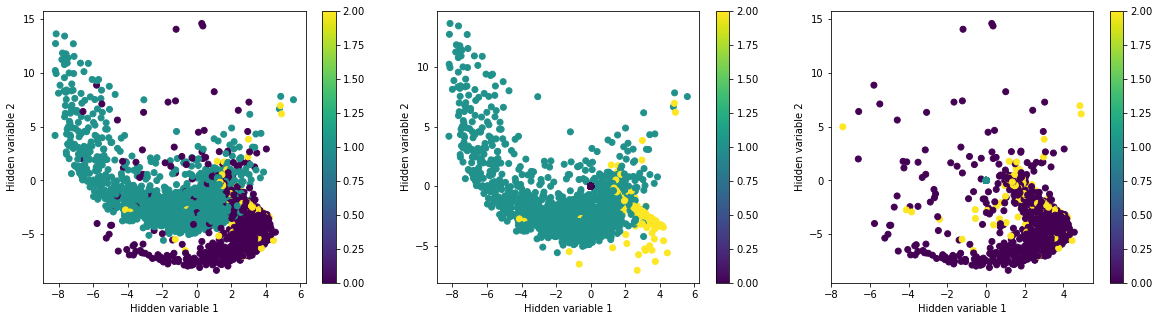

In [8]:
label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =np.argmax(train_label[i])

vis = Model(input_img, z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(train_data[8500:14000], batch_size=batch_size)

x_vis_1 = vis.predict(train_data[8500:14000], batch_size=batch_size)  
x_vis_1[label_value[8500:14000]<1]=0

x_vis_2 = vis.predict(train_data[8500:14000], batch_size=batch_size)  
x_vis_2[label_value[8500:14000]==1]=0

plt.figure(figsize=(20, 5))

ax = plt.subplot(1,3,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[8500:14000])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,2)
plt.scatter( x_vis_1[:, 0] ,x_vis_1[:, 1],c=label_value[8500:14000])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,3)
plt.scatter( x_vis_2[:, 0] ,x_vis_2[:, 1],c=label_value[8500:14000])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

## Kmeans clustering

In [9]:
kmeans = cluster.KMeans(n_clusters=2, max_iter=300, n_jobs=1, precompute_distances=True)
cluster_labels = kmeans.fit_predict(x_vis)

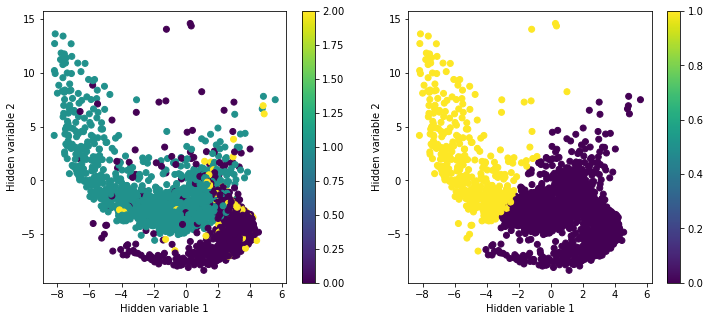

In [10]:
plt.figure(figsize=(12, 5))

ax = plt.subplot(1,2,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[8500:14000])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,2,2)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=cluster_labels)
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

## DBSCAN clustering

In [11]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.5, min_samples=200).fit(x_vis)
labels = db.labels_

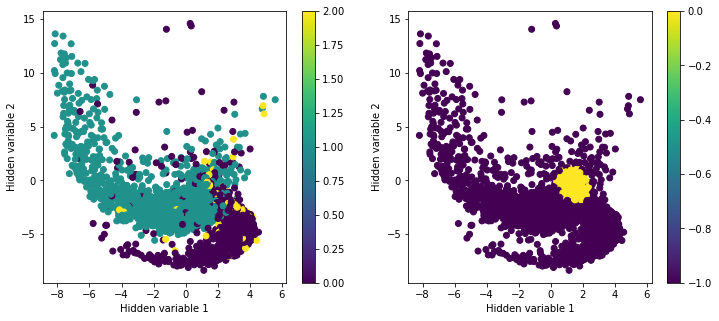

In [12]:
plt.figure(figsize=(12, 5))

ax = plt.subplot(1,2,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[8500:14000])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,2,2)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=labels)
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

## Spectral clustering

In [13]:
from sklearn.cluster import SpectralClustering
spectr = SpectralClustering(n_clusters=3).fit(x_vis)

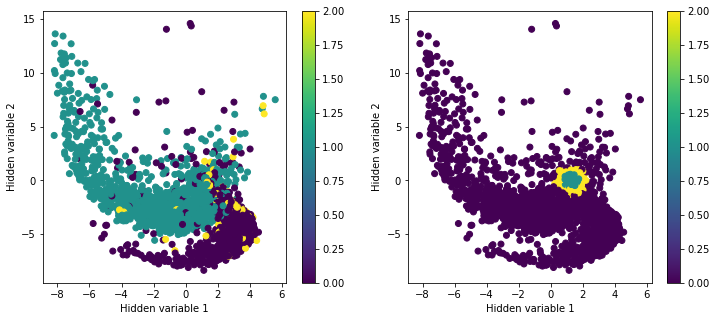

In [14]:
plt.figure(figsize=(12, 5))

ax = plt.subplot(1,2,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[8500:14000])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,2,2)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=spectr.labels_)
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

## Manifold learning clustering
### SpectralEmbedding

In [15]:
from sklearn import manifold

In [16]:
n_points = np.shape(x_vis)[0]
n_neighbors = 10
n_components = 1
X = np.asarray(x_vis,dtype='float64')
se = manifold.SpectralEmbedding(n_components=n_components,
                                n_neighbors=n_neighbors)
Y = se.fit_transform(X)

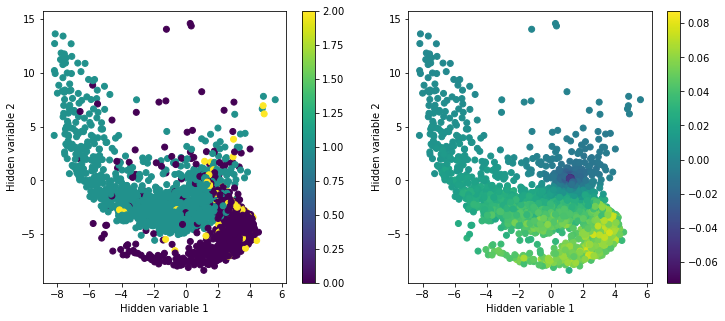

In [17]:
plt.figure(figsize=(12, 5))

ax = plt.subplot(1,2,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[8500:14000])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,2,2)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=Y)
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

## Manifold learning clustering
### t-SNE

In [18]:
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
Y = tsne.fit_transform(X)

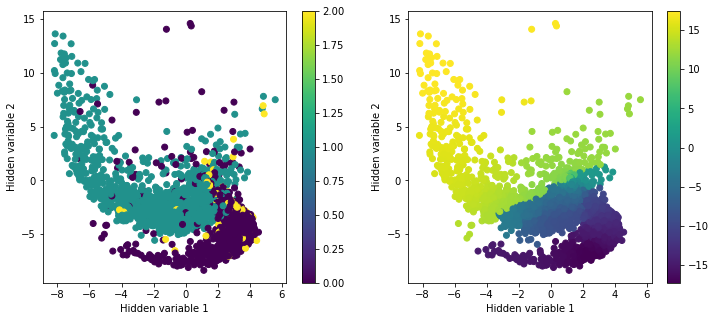

In [19]:
plt.figure(figsize=(12, 5))

ax = plt.subplot(1,2,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[8500:14000])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,2,2)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=Y)
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

## Manifold learning clustering
### ISOMAP

In [23]:
isomap = manifold.Isomap(n_neighbors, n_components)
hid_pred = vis.predict(train_data, batch_size=batch_size)
Y_pred = isomap.fit_transform(hid_pred)

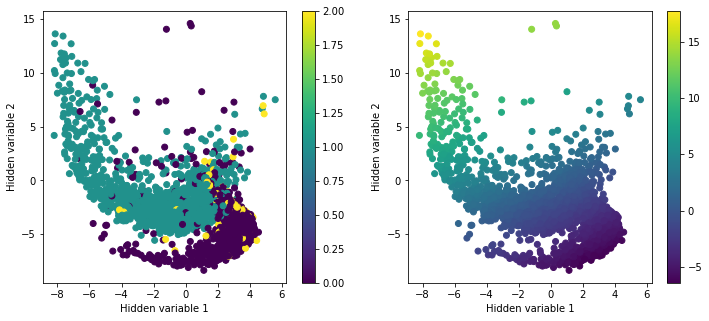

In [24]:
plt.figure(figsize=(12, 5))

ax = plt.subplot(1,2,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[8500:14000])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,2,2)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=Y_pred[8500:14000])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

In [90]:
count_ = 0
for i in range(len(Y)):
    if Y_pred[8500:14000][i]> -0.543:
        count_+=1
print("predict abs with threshold above:\n",count_/len(Y)-np.sum(Class[Class==1])/14142)
print(" %.4g" % float(np.sum(Class[Class==1])/14142*100),"%")

predict abs with threshold above:
 0.000181098211645
 67.85 %


### Try to use Y as threshold to perform classification. 

In [91]:
count_gala = 0
for i in range(len(hid_pred)):
    if (Y_pred[i] > -0.543):
        if Class[i]==1:
            count_gala+=1
print(count_gala/np.sum(Class[Class==1]))
print(np.sum(Class[Class==1])-count_gala)

0.815339724885
1772


In [92]:
count_star = 0
for i in range(len(hid_pred)):
    if (Y_pred[i] < -0.543):
        if Class[i]==0:
            count_star+=1
print(count_star/(len(hid_pred) - np.sum(Class[Class==1]) -np.sum(Class[Class==2])/2))
print((len(hid_pred) - np.sum(Class[Class==1]) -np.sum(Class[Class==2])/2)-count_star)

0.664343462503
1204.0


In [93]:
print("total accuracy is:",1-((np.sum(Class[Class==1])-count_gala)+(len(hid_pred) - np.sum(Class[Class==1]) -np.sum(Class[Class==2])/2)-count_star)/len(Y_pred))

total accuracy is: 0.789563003818


# Hypercolumns + Classification

In [54]:
model_conv_1 = Model(input_img,conv_1)
model_pool_1 = Model(input_img,maxpool_1)
model_conv_2 = Model(input_img,conv_2)
model_pool_2 = Model(input_img,maxpool_2)
model_conv_3 = Model(input_img,conv_3)
model_pool_3 = Model(input_img,maxpool_3)
model_conv_4 = Model(input_img,conv_4)
model_pool_4 = Model(input_img,maxpool_4)
model_conv_5 = Model(input_img,conv_5)
model_pool_5 = Model(input_img,maxpool_5)
vis = Model(input_img, z_mean)
model_conv_6 = Model(input_img,conv_6)
model_up_6 = Model(input_img,upsample_6)
model_conv_7 = Model(input_img,conv_7)
model_up_7 = Model(input_img,upsample_7)
model_conv_8 = Model(input_img,conv_8)
model_up_8 = Model(input_img,upsample_8)
model_conv_9 = Model(input_img,conv_9)
model_up_9 = Model(input_img,upsample_9)
model_conv_10 = Model(input_img,conv_10)
model_up_10 = Model(input_img,upsample_10)

In [55]:
lyr = []
lyr.append(model_conv_1)
lyr.append(model_pool_1)
lyr.append(model_conv_2)
lyr.append(model_pool_2)
lyr.append(model_conv_3)
lyr.append(model_pool_3)
lyr.append(model_conv_4)
lyr.append(model_pool_4)
lyr.append(model_conv_5)
lyr.append(model_pool_5)
lyr.append(vis)
lyr.append(model_conv_6)
lyr.append(model_up_6)
lyr.append(model_conv_7)
lyr.append(model_up_7)
lyr.append(model_conv_8)
lyr.append(model_up_8)
lyr.append(model_conv_9)
lyr.append(model_up_9)
lyr.append(model_conv_10)
lyr.append(model_up_10)

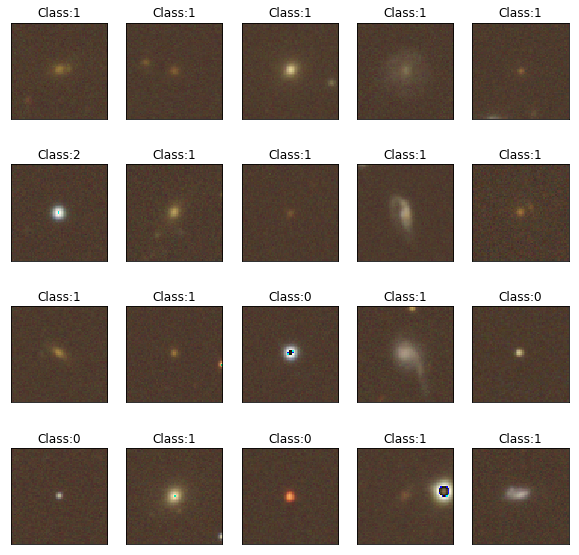

In [57]:
plt.figure(figsize=(10, 10))
for number in range(20):
    ax = plt.subplot(4,5,number+1)
    plt.imshow(1-show_Image_RGB[10000+number][:,:,1:4])
    plt.title("Class:%g" %(Class[10000+number]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [72]:
import scipy
RANGE=20
total_hyp = []
for No_ in range(RANGE):
    hypercolumns = []
    hypercolumns_class = []
    for i in range(np.shape(lyr)[0]-18):
        for l in range(lyr[i].output_shape[3]):
            hypercolumns.append(scipy.misc.imresize(lyr[i].predict(train_data[10000:10100],batch_size=100)[No_,:,:,l],size=(64,64),mode="F", interp='bilinear'))
    total_hyp.append(hypercolumns)

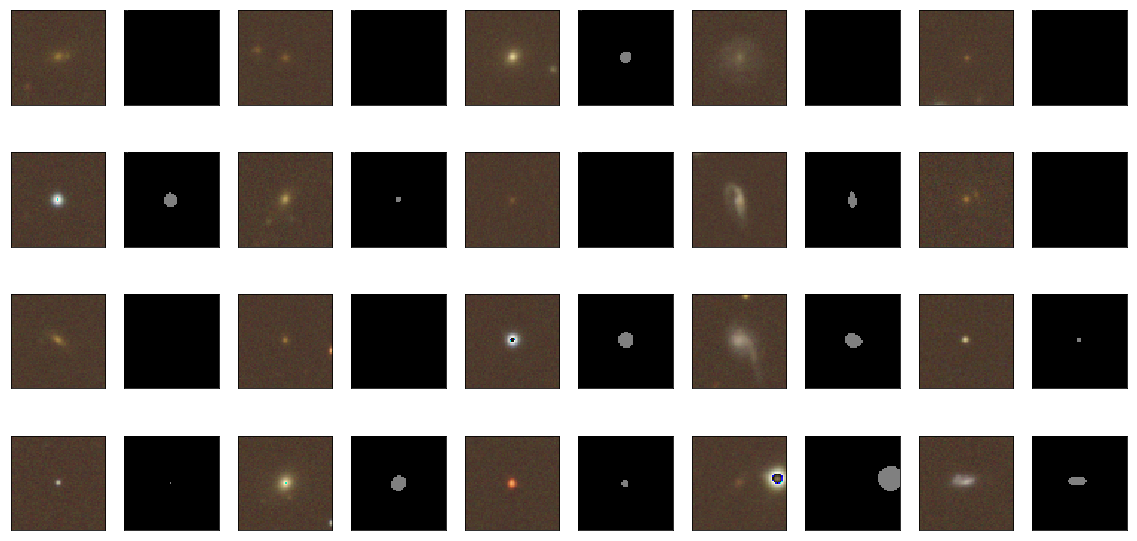

In [73]:
total_hyp = np.asarray(total_hyp)
m=total_hyp.transpose(0,2,3,1).reshape(64*64*RANGE,-1)
kmeans = cluster.KMeans(n_clusters=2, max_iter=300, n_jobs=1, precompute_distances=True)
#SC = SpectralClustering(n_clusters=2).fit(m)
cluster_labels = kmeans.fit_predict(m)
imcluster = cluster_labels
for i in range(RANGE):
    imcluster[i*64*64:(i+1)*64*64][0]=0
    imcluster[i*64*64:(i+1)*64*64][1]=1
    imcluster[i*64*64:(i+1)*64*64][2]=2

fig = plt.figure(figsize=(20, 10))
for i in range(RANGE):
    ax = plt.subplot(4,10,i*2+1)
    plt.imshow(1-show_Image_RGB[10000+i][:,:,1:4])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(4,10,i*2+2)
    plt.imshow(imcluster[i*64*64:(i+1)*64*64].reshape(64, 64), cmap="Set2")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.gray()
plt.show()

In [74]:
import scipy
RANGE=20
total_hyp = []
for No_ in range(RANGE):
    hypercolumns = []
    hypercolumns_class = []
    for i in range(np.shape(lyr)[0]-19):
        for l in range(lyr[i].output_shape[3]):
            hypercolumns.append(scipy.misc.imresize(lyr[i].predict(train_data[10000:10100],batch_size=100)[No_,:,:,l],size=(64,64),mode="F", interp='bilinear'))
    total_hyp.append(hypercolumns)

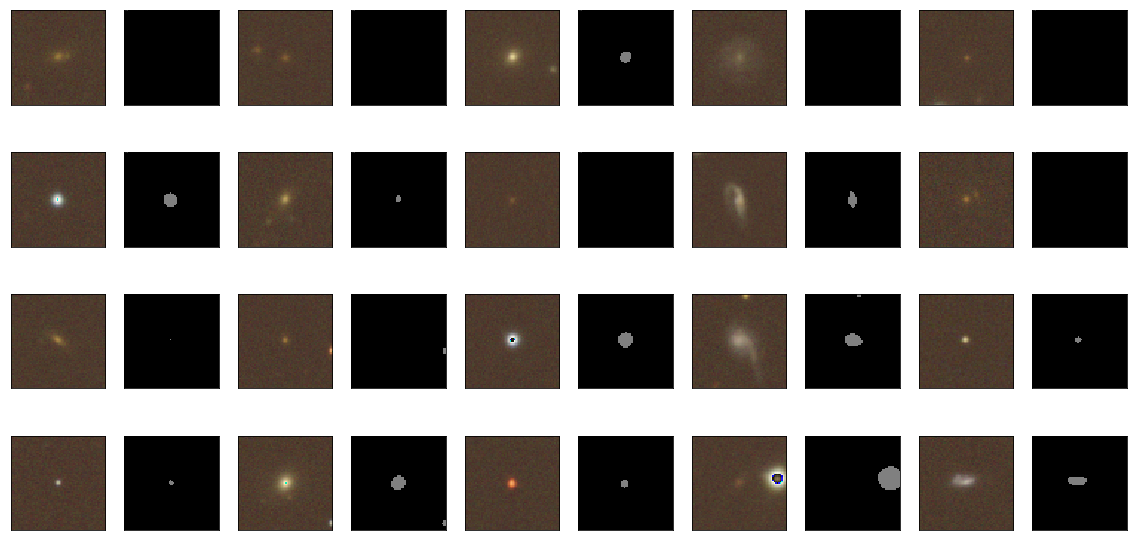

In [75]:
total_hyp = np.asarray(total_hyp)
m=total_hyp.transpose(0,2,3,1).reshape(64*64*RANGE,-1)
kmeans = cluster.KMeans(n_clusters=2, max_iter=300, n_jobs=1, precompute_distances=True)
cluster_labels = kmeans.fit_predict(m)
imcluster = cluster_labels
for i in range(RANGE):
    imcluster[i*64*64:(i+1)*64*64][0]=0
    imcluster[i*64*64:(i+1)*64*64][1]=1
    imcluster[i*64*64:(i+1)*64*64][2]=2

fig = plt.figure(figsize=(20, 10))
for i in range(RANGE):
    ax = plt.subplot(4,10,i*2+1)
    plt.imshow(1-show_Image_RGB[10000+i][:,:,1:4])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(4,10,i*2+2)
    plt.imshow(imcluster[i*64*64:(i+1)*64*64].reshape(64, 64), cmap="Set2")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.gray()
plt.show()

In [76]:
import scipy
RANGE=20
total_hyp = []
for No_ in range(RANGE):
    hypercolumns = []
    hypercolumns_class = []
    for i in range(np.shape(lyr)[0]-11):
        for l in range(lyr[i].output_shape[3]):
            hypercolumns.append(scipy.misc.imresize(lyr[i].predict(train_data[10000:10100],batch_size=100)[No_,:,:,l],size=(64,64),mode="F", interp='bilinear'))
    total_hyp.append(hypercolumns)

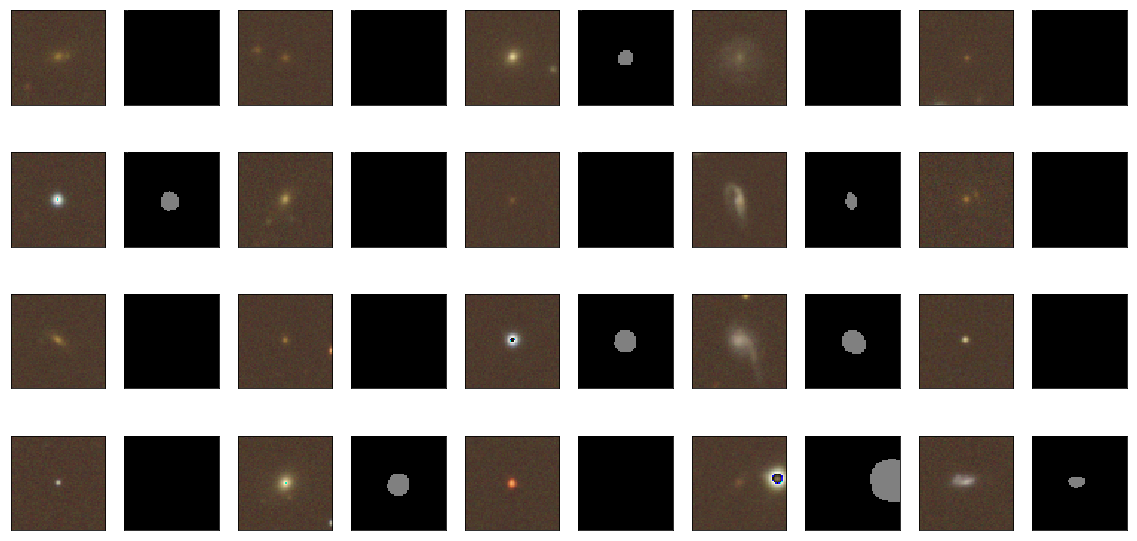

In [77]:
total_hyp = np.asarray(total_hyp)
m=total_hyp.transpose(0,2,3,1).reshape(64*64*RANGE,-1)
kmeans = cluster.KMeans(n_clusters=2, max_iter=300, n_jobs=1, precompute_distances=True)
cluster_labels = kmeans.fit_predict(m)
imcluster = cluster_labels
for i in range(RANGE):
    imcluster[i*64*64:(i+1)*64*64][0]=0
    imcluster[i*64*64:(i+1)*64*64][1]=1
    imcluster[i*64*64:(i+1)*64*64][2]=2

fig = plt.figure(figsize=(20, 10))
for i in range(RANGE):
    ax = plt.subplot(4,10,i*2+1)
    plt.imshow(1-show_Image_RGB[10000+i][:,:,1:4])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(4,10,i*2+2)
    plt.imshow(imcluster[i*64*64:(i+1)*64*64].reshape(64, 64), cmap="Set2")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.gray()
plt.show()

## Classification

In [101]:
import scipy
RANGE=40
total_hyp = []
for No_ in range(RANGE):
    hypercolumns = []
    hypercolumns_class = []
    for i in range(np.shape(lyr)[0]-18):
        for l in range(lyr[i].output_shape[3]):
            hypercolumns.append(scipy.misc.imresize(lyr[i].predict(train_data[10000:10100],batch_size=100)[No_,:,:,l],size=(64,64),mode="F", interp='bilinear'))
    total_hyp.append(hypercolumns)

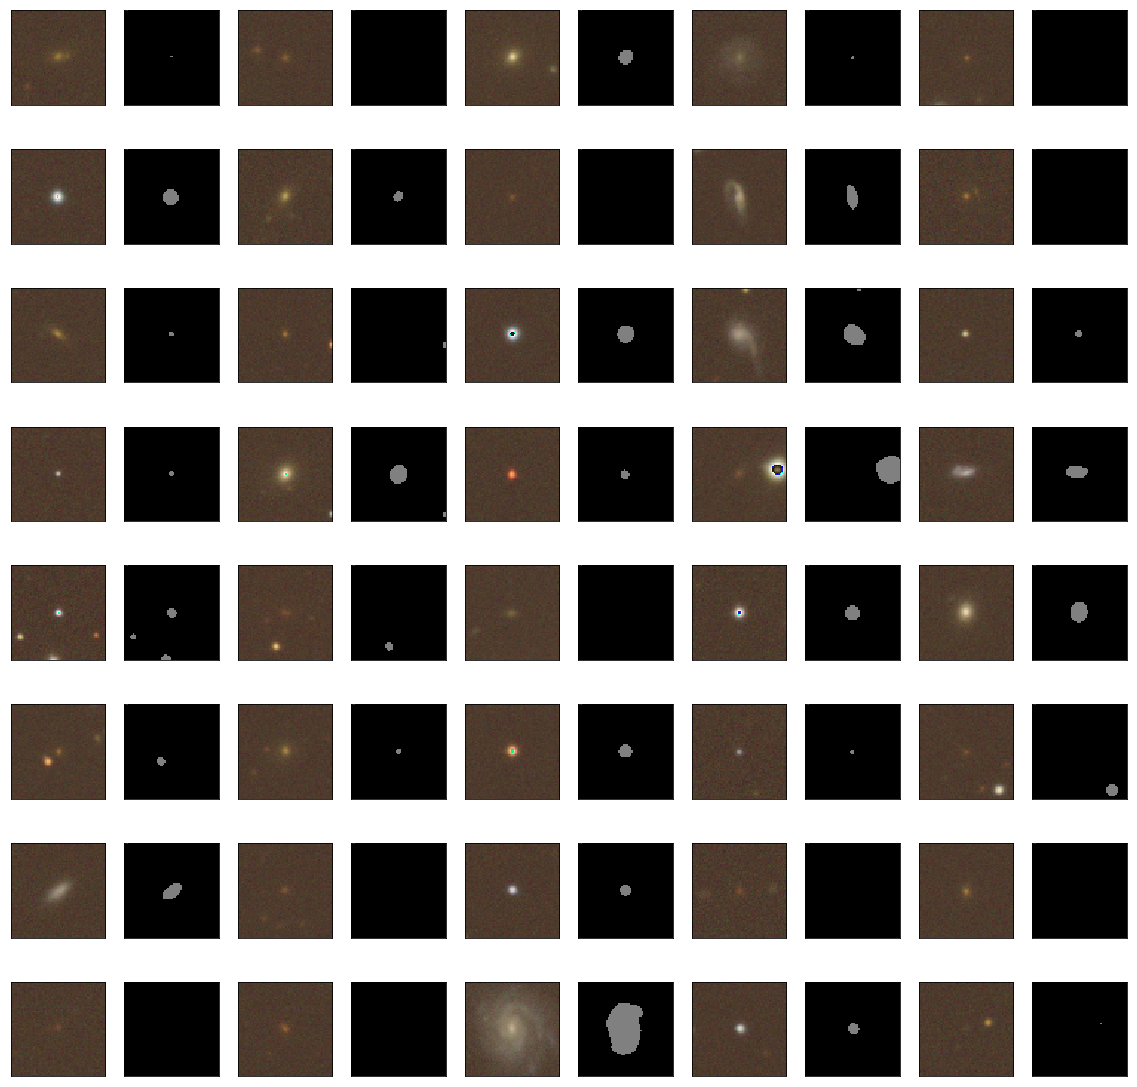

In [108]:
total_hyp = np.asarray(total_hyp)
m=total_hyp.transpose(0,2,3,1).reshape(64*64*RANGE,-1)
kmeans = cluster.KMeans(n_clusters=2, max_iter=300, n_jobs=1, precompute_distances=True)
#SC = SpectralClustering(n_clusters=2).fit(m)
cluster_labels = kmeans.fit_predict(m)
imcluster = cluster_labels
for i in range(RANGE):
    imcluster[i*64*64:(i+1)*64*64][0]=0
    imcluster[i*64*64:(i+1)*64*64][1]=1
    imcluster[i*64*64:(i+1)*64*64][2]=2

fig = plt.figure(figsize=(20, 20))
for i in range(RANGE):
    ax = plt.subplot(8,10,i*2+1)
    plt.imshow(1-show_Image_RGB[10000+i][:,:,1:4])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(8,10,i*2+2)
    plt.imshow(imcluster[i*64*64:(i+1)*64*64].reshape(64, 64), cmap="Set2")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.gray()
plt.show()

In [109]:
unsup_class = lyr[10].predict(train_data[10000:10100],batch_size=100)

for i in range(RANGE):
    if Y_pred[10000:10100][i] > -0.543:
        imcluster[i*64*64:(i+1)*64*64][imcluster[i*64*64:(i+1)*64*64]==1] =2
        imcluster[i*64*64:(i+1)*64*64][imcluster[i*64*64:(i+1)*64*64]==0] =0
        imcluster[i*64*64:(i+1)*64*64][0]=0
        imcluster[i*64*64:(i+1)*64*64][1]=1
        imcluster[i*64*64:(i+1)*64*64][2]=2
    else:
        imcluster[i*64*64:(i+1)*64*64][imcluster[i*64*64:(i+1)*64*64]==1] =1
        imcluster[i*64*64:(i+1)*64*64][imcluster[i*64*64:(i+1)*64*64]==0] =0
        imcluster[i*64*64:(i+1)*64*64][0]=0
        imcluster[i*64*64:(i+1)*64*64][1]=1
        imcluster[i*64*64:(i+1)*64*64][2]=2

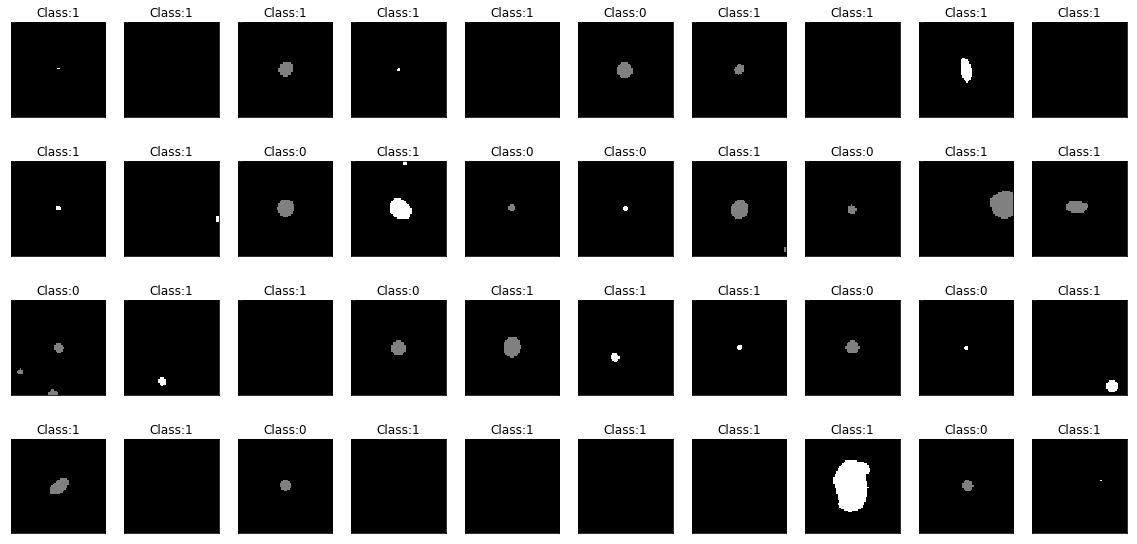

gray: Stars, Class:0,2 correspond to stars(or like stars)
white: Galaxies, Class:1 correspond to galaxies


In [129]:
fig = plt.figure(figsize=(20, 20))
label_pred = np.ones((RANGE,))*2
for i in range(RANGE):
    ax = plt.subplot(8,10,i+1)
    plt.imshow(imcluster[i*64*64:(i+1)*64*64].reshape(64, 64), cmap="Set1")
    if np.sum(imcluster[i*64*64:(i+1)*64*64][imcluster[i*64*64:(i+1)*64*64]==1])>=2:
        label_pred[i] = 0
    if np.sum(imcluster[i*64*64:(i+1)*64*64][imcluster[i*64*64:(i+1)*64*64]==2])>=4:
        label_pred[i] = 1
    plt.title("Class:%g" %(Class[10000+i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.gray()
plt.show()
print("gray: Stars, Class:0,2 correspond to stars(or like stars)")
print("white: Galaxies, Class:1 correspond to galaxies")

In [130]:
label_pred

array([ 1.,  2.,  0.,  1.,  2.,  0.,  0.,  2.,  1.,  2.,  1.,  1.,  0.,
        1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  0.,  0.,  1.,
        1.,  0.,  1.,  1.,  0.,  2.,  0.,  2.,  2.,  2.,  2.,  1.,  0.,  1.])

In [131]:
Class[10000:10040][Class[10000:10040]==2]=0

In [132]:
Class[10000:10040]

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1])

In [133]:
corr = 0
total_pred = 0
for i in range(RANGE):
    if label_pred[i]!=2:
        total_pred+=1
        if label_pred[i]==Class[10000:10040][i]:
            corr+=1
print("acc =", corr/total_pred)

acc = 0.7


In [136]:
print("Sensitivity:",total_pred/RANGE)

Sensitivity: 0.75


# Regression for Redshift
## Only use galaxy images

In [137]:
reg_data = []
reg_redshift = []
for i in range(len(train_data)):
    if Class[i]==1:
        reg_data.append(train_data[i])
        reg_redshift.append(Redshift[i])

In [138]:
reg_data = np.asarray(reg_data)
reg_redshift = np.asarray( reg_redshift)
reg_redshift /= np.max(reg_redshift)

In [150]:
batch_size =100
latent_dim = 1
nb_epoch = 50  
epsilon_std = 1.0  
intermediate_dim_1 = 300
#intermediate_dim_2 = 300
original_dim = 64*64

LRelu = keras.layers.advanced_activations.LeakyReLU(alpha=0.3)

input_img = Input(shape=(64,64,5))
x = Conv2D(40, (3, 3), padding='same',kernel_initializer='normal')(input_img)
x = Activation(LRelu)(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)


conv_1 = Conv2D(40, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(x)
maxpool_1 = MaxPooling2D((2, 2),  padding='same')(conv_1)
maxpool_1 = Dropout(0.25)(maxpool_1)

x = Conv2D(40, (3, 3),padding='same',kernel_initializer='normal')(maxpool_1)
x = Activation(LRelu)(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

conv_2 = Conv2D(40, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(x)
maxpool_2 = MaxPooling2D((2, 2),  padding='same')(conv_2)
maxpool_2 = Dropout(0.25)(maxpool_2)

x = Conv2D(40, (3, 3),padding='same',kernel_initializer='normal')(maxpool_2)
x = Activation(LRelu)(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

conv_3 = Conv2D(20, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(x)
maxpool_3 = MaxPooling2D((2, 2),  padding='same')(conv_3)
maxpool_3 = Dropout(0.25)(maxpool_3)

conv_4 = Conv2D(20, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(maxpool_3)
maxpool_4 = MaxPooling2D((2, 2),  padding='same')(conv_4)
maxpool_4 = Dropout(0.25)(maxpool_4)

conv_5 = Conv2D(20, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(maxpool_4)
maxpool_5 = MaxPooling2D((2, 2),  padding='same')(conv_5)
maxpool_5 = Dropout(0.25)(maxpool_5)

visual = Flatten()(maxpool_5)
h_1 = Dense(intermediate_dim_1, activation=LRelu)(visual)
h_1 = Dropout(0.25)(h_1)
redshift = Dense(latent_dim, activation='sigmoid')(h_1)


EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')
checkpoint = ModelCheckpoint('regression.h5',monitor = 'val_loss',verbose = 1,save_best_only = True)

model = Model(inputs=input_img, outputs=redshift)
model.compile(optimizer='rmsprop', loss='mean_squared_error')

In [158]:
model.fit(reg_data[:8000], reg_redshift[:8000],
        shuffle=True,
        epochs=50,
        batch_size=10,
        validation_data=(reg_data[8000:9500],reg_redshift[8000:9500]),callbacks=[EarlyStopping])  

Train on 8000 samples, validate on 1500 samples
Epoch 1/50
8000/8000 [==============================] - 26s - loss: 0.0078 - val_loss: 0.0040
Epoch 2/50
8000/8000 [==============================] - 26s - loss: 0.0058 - val_loss: 0.0038
Epoch 3/50
8000/8000 [==============================] - 26s - loss: 0.0050 - val_loss: 0.0037
Epoch 4/50
8000/8000 [==============================] - 26s - loss: 0.0046 - val_loss: 0.0032
Epoch 5/50
8000/8000 [==============================] - 26s - loss: 0.0044 - val_loss: 0.0039
Epoch 6/50
8000/8000 [==============================] - 26s - loss: 0.0044 - val_loss: 0.0032
Epoch 7/50
8000/8000 [==============================] - 26s - loss: 0.0042 - val_loss: 0.0031
Epoch 8/50
8000/8000 [==============================] - 27s - loss: 0.0041 - val_loss: 0.0037
Epoch 9/50
8000/8000 [==============================] - 27s - loss: 0.0039 - val_loss: 0.0028
Epoch 10/50
8000/8000 [==============================] - 26s - loss: 0.0039 - val_loss: 0.0035
Epoch 11/50

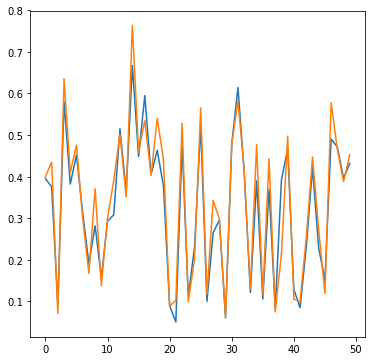

In [159]:
rdsft_predict = model.predict(reg_data[100:150])
plt.figure(figsize=(6, 6))
plt.plot(rdsft_predict)
plt.plot(reg_redshift[100:150])
#plt.colorbar()
plt.show()

In [160]:
rdsft_predict = model.predict(reg_data[9400:9500])

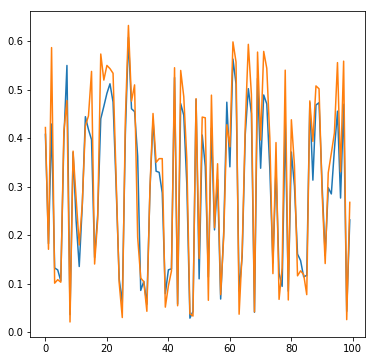

In [161]:
plt.figure(figsize=(6, 6))
plt.plot( rdsft_predict)
plt.plot(reg_redshift[9400:9500])
#plt.colorbar()
plt.show()

In [162]:
red_pred_1 = model.predict(reg_data[8000:8500])

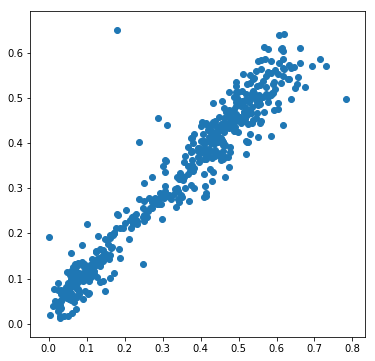

In [163]:
plt.figure(figsize=(6, 6))
plt.scatter( reg_redshift[8000:8500],red_pred_1)
plt.show()